In [1]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt
import numpy as np

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [55]:
# Lower level imports
from algo.prox import prox_G,prox_F1_dual,prox_F2_dual
from algo.pdhg import pdhg
from algo.cost_utils import *

#Upper level imports
from scipy.sparse.linalg import cg,LinearOperator
import scipy
import time

In [3]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=512
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(np.real(u0_mat))+1e-6*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [73]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
radial_p = np.zeros((n*n+1,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
radial_p[n*ind1+ind2]=1
radial_p[-1]=1e-6
p = np.copy(radial_p)

#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=4,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

# Definition of functions
Only for one linear operator for the moment (wavelet).

In [5]:
param = {"zeta":1e15,"pn1":p[-1],"epsilon":1e-5,"gamma":1e-10}

#Definition of phi=rho'(x)/x and psi=phi'(x)/x
def rho(x):
    if x<-param["gamma"]:return -x-param["gamma"]/3
    elif x<0:return x**3/3/param["gamma"]**2+x**2/param["gamma"]
    elif x<param["gamma"]:return -x**3/param["gamma"]**2/3+x**2/param["gamma"]
    else:return x-param["gamma"]/3
    
def phi(x):
    if x<-param["gamma"]:return -1/x
    elif x<0:return x/param["gamma"]**2+2/param["gamma"]
    elif x<param["gamma"]:return -x/param["gamma"]**2+2/param["gamma"]
    else:return 1/x

def psi(x):
    x=abs(x)
    if x<param["gamma"]:return -1/param["gamma"]**2/x
    else:return -1/x**3


def rho_vec(x):
    x = np.abs(x)
    return np.where(x<param["gamma"],-x**3/3/param["gamma"]**2+x**2/param["gamma"],x-param["gamma"]/3)

def phi_vec(x):
    x = np.abs(x)
    return np.where(x<=param["gamma"],-x/param["gamma"]**2+2/param["gamma"],1/x)

def psi_vec(x):
    x = np.abs(x)
    return np.where(x<param["gamma"],-1/x/param["gamma"]**2,-1/x**3)

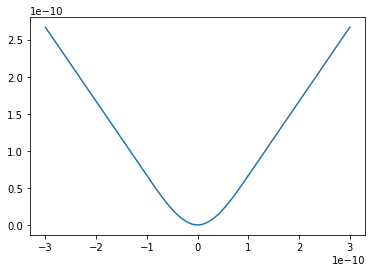

In [6]:
x = np.linspace(-3*param["gamma"],3*param["gamma"],200)
plt.plot(x,rho_vec(x))

# Functions and first order derivatives

In [7]:
#Base functions
Eeps = lambda x:param["epsilon"]/2*np.linalg.norm(x)**2
Edata = lambda x:f1(x,p[:-1],y,fourier_op)
Enonneg = lambda x:b(x,param["zeta"])
Ereg = lambda x:param["pn1"]*np.sum(rho_vec(linear_op.op(x)))
Etot = lambda x:Eeps(x)+Edata(x)+Enonneg(x)+Ereg(x)

#First order derivatives
Du_Eeps = lambda x:param["epsilon"]*x
Du_Edata = lambda x:np.real(fourier_op.adj_op(p[:-1]**2*(fourier_op.op(Rstar(x))-y)))
Du_Enonneg = lambda x:-3*param["zeta"]*np.where(x<=0,x**2,0)
Du_Ereg = lambda x:param["pn1"]*linear_op.adj_op(phi_vec(linear_op.op(x))*linear_op.op(x))
Du_Etot = lambda x:Du_Eeps(x)+Du_Edata(x)+Du_Enonneg(x)+Du_Ereg(x)

### Numerical check
Plots of $\left|\frac{f(a+th)-f(a)-<\nabla f(a),th>}{t}\right|$ for $t\rightarrow 0$. Eeps, Edata and Enonneg seem to work, but problem with Ereg.

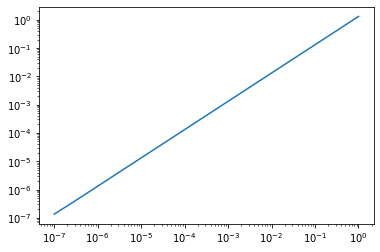

In [8]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

tests = np.logspace(-7,0,20)
real_values = np.array([Eeps(a+t*a2) for t in tests])
approx = np.array([Eeps(a)+t*np.sum(Du_Eeps(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

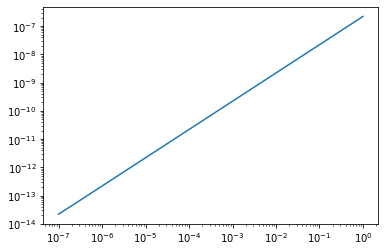

In [9]:
# -- Edata --
#Random vector with same amplitude as u0
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)


tests = np.logspace(-7,0,20)
real_values = np.array([Edata(u0_mat+t*a2) for t in tests])
approx = np.array([Edata(u0_mat)+t*np.sum(Du_Edata(u0_mat)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

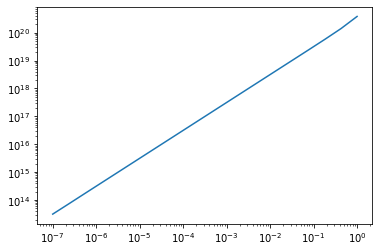

In [10]:
# -- Enonneg --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

tests = np.logspace(-7,0,20)
real_values = np.array([Enonneg(a+t*a2) for t in tests])
approx = np.array([Enonneg(a)+t*np.sum(Du_Enonneg(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

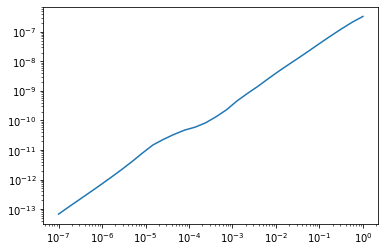

In [64]:
# -- Ereg --
#Random vector with same amplitude as u0
a = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)

tests = np.logspace(-7,-0,30)
real_values = np.array([Ereg(a+t*a2) for t in tests])
approx = np.array([Ereg(a)+t*np.sum(Du_Ereg(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

In [66]:
print(Ereg(a))

7.987135584484222e-07


Gap between limits:6.776263578034403e-21


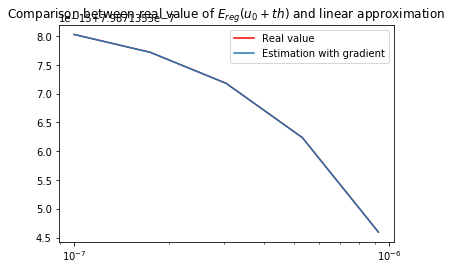

In [65]:
print(f"Gap between limits:{real_values[0]-approx[0]}")

plt.plot(tests[:5],real_values[:5],'r',label="Real value")
plt.plot(tests[:5],approx[:5],label="Estimation with gradient")
plt.xscale("log")
plt.title("Comparison between real value of $E_{reg}(u_0+th)$ and linear approximation")
plt.legend()

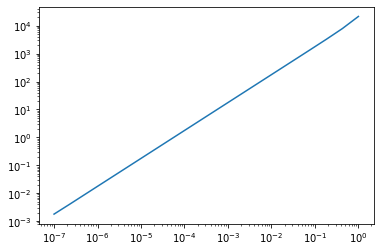

In [68]:
# -- Etot --
#Random vector with same amplitude as u0
a2 = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)
a = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)
#a=u0_mat

tests = np.logspace(-7,0,20)
real_values = np.array([Etot(a+t*a2) for t in tests])
approx = np.array([Etot(a)+t*np.sum(Du_Etot(a)*a2)for t in tests])

plt.plot(tests,(real_values-approx)/tests)
plt.xscale("log")
plt.yscale("log")

# Second order derivatives
We don't express the hessians as matrices but as linear operators. Same verifications: $\frac{||\nabla f(a+th)-(\nabla f(a)+t\nabla^2f(a)h)||_2}{t}$.

In [26]:
def Du2_Eeps(u,p,w):return param["epsilon"]*w
def Du2_Edata(u,p,w):return np.real(fourier_op.adj_op(p[:-1]**2*fourier_op.op(w)))
def Du2_Enonneg(u,p,w):return -6*param["zeta"]*np.where(u<0,u,0)*w
def Du2_Ereg(u,p,w):
    lin_u = linear_op.op(u)
    lin_w = linear_op.op(w)
    psi_Au = psi_vec(lin_u)
    phi_Au = phi_vec(lin_u)
    return param["pn1"]*(linear_op.adj_op(lin_u**2*lin_w*psi_Au)+linear_op.adj_op(phi_Au*lin_w))
def Du2_Etot(u,p,w):return Du2_Eeps(u,p,w)+Du2_Edata(u,p,w)+Du2_Enonneg(u,p,w)+Du2_Ereg(u,p,w)

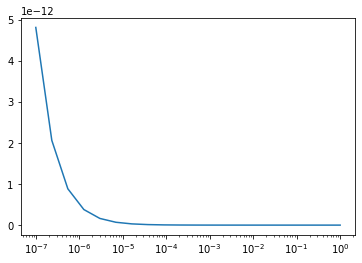

In [80]:
# -- Eeps --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Eeps(a+t*a2))
    approx.append(Du_Eeps(a)+Du2_Eeps(a,p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
#plt.plot(tests,vals2,'r')
plt.xscale("log")
plt.yscale("log")

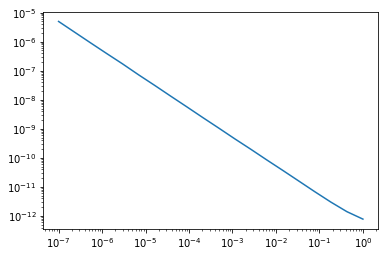

In [89]:
# -- Edata --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Edata(a+t*a2))
    approx.append(Du_Edata(a)+Du2_Edata(a,p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

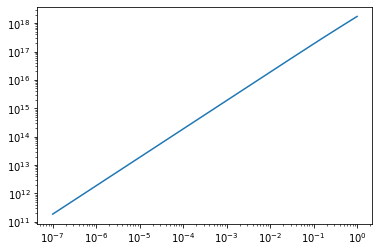

In [83]:
# -- Enonneg --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Enonneg(a+t*a2))
    approx.append(Du_Enonneg(a)+Du2_Enonneg(a,p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

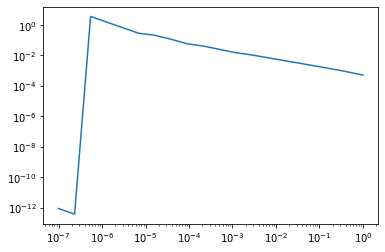

In [88]:
# -- Ereg --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Ereg(a+t*a2))
    approx.append(Du_Ereg(a)+Du2_Ereg(a,p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

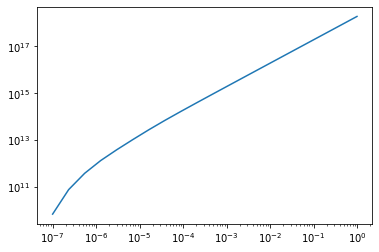

In [87]:
# -- Etot --
#Two random vectors with same amplitude
a = np.random.randn(n**2).reshape((n,n))
a=u0_mat
a2 = np.random.randn(n**2).reshape((n,n))

ntest=20
tests = np.logspace(-7,0,ntest)
real = []
approx = []
for t in tests:
    real.append(Du_Etot(a+t*a2))
    approx.append(Du_Etot(a)+Du2_Etot(a,p,t*a2))

plt.plot(tests,np.array([np.linalg.norm(real[i]-approx[i]) for i in range(ntest)])/tests)
plt.xscale("log")
plt.yscale("log")

## Cross derivatives

In [36]:
def Dpu_Edata(u,p,w):
    Fu = np.conj(fourier_op.op(Rstar(u))-y)
    Fw = fourier_op.op(w)
    return 2*np.real(p[:-1]*Fu*Fw)
def Dpu_Ereg(u,p,w):
    return param["pn1"]*np.sum(w*linear_op.adj_op(phi_vec(linear_op.op(u))*linear_op.op(u)))

def Dpu_Etot(u,p,w):
    g = np.zeros((n**2+1,))
    g[:-1] = Dpu_Edata(u,p,w)
    g[-1] = Dpu_Ereg(u,p,w)
    return g

In [77]:
# -- Ereg --
#Random vector with same amplitude as u0
p2 = -1*np.random.randn(n**2+1)
p2[-1] = -p2[-1]
a = np.random.randn(n**2).reshape((n,n))/n*np.linalg.norm(u0_mat)

ntest=20
tests = np.logspace(-7,0,ntest)

for i in range(ntest):
    p=radial_p+tests[i]*p2
    real_values[i] = Du_Ereg(a)

plt.plot(tests,abs((real_values)))
plt.xscale("log")
plt.yscale("log")

ValueError: setting an array element with a sequence.

## Loss function and penalty

In [37]:
c = 1e0
def L(u,u2):return c*np.linalg.norm(u-u2)**2
def grad_L(u,u2):return 2*c*(u-u2)

beta = 1e-10*c
def P(p):return beta*np.sum(p[:-1]*(2-p[:-1]))
def grad_P(p):
    Dp = 2*(1-p)
    #Don't change alpha
    Dp[-1] = 0
    return beta*Dp
# P = lambda x:beta*np.linalg.norm(p)**2
# grad_P = lambda x:2*beta*x

In [38]:
param["pn1"]=1e-6
uk,norms,energy = pdhg(y,p[:-1],fourier_op,linear_op,param,maxit=20,verbose=0)
print(f"L(u(p))={L(uk,u0_mat)}\nP(p)={P(p)}")

/home/guillaume/pysap-mri/Lower Level/algo/prox.py:14: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))
/home/guillaume/pysap-mri/Lower Level/algo/prox.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.where(x>=0,x/(1+epsilon*c),x/(0.5+np.sqrt(0.25-3*zeta*c*x/(1+epsilon*c)**2)))


Finished in 9.977968215942383 seconds.
L(u(p))=8.299837895169603e-08
P(p)=2.9767000000000002e-06


In [79]:
print(np.linalg.norm(grad_L(uk,u0_mat)),np.linalg.norm(grad_P(0.9*p[:-1])))

0.000575910517861788 9.647251836663137e-08


# Upper level energy

In [61]:
uk = np.zeros(u0_mat.shape)

def E(pk):
    global uk
    print("\nEvaluating E(p)")
    param["pn1"]=pk[-1]
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=20,verbose=0)
    return L(uk,u0_mat)+P(pk)

cgconv = []
def grad_E(pk,max_cgiter=100,compute_conv=False):
    global uk,cgconv
    #Update alpha(p)
    param["pn1"]=pk[-1]
    
    print("\nStarting PDHG")
    uk,norms = pdhg(y,pk[:-1],fourier_op,linear_op,param,compute_energy=False,maxit=20,verbose=0)
    
    def mv(w):
        w = np.reshape(w,(n,n))
        return np.reshape(Du2_Etot(uk,pk,w),(n**2,))
    
    
    # -- Use cg to compute gradient --
    lin = LinearOperator((n**2,n**2),matvec=mv)
    B = np.reshape(grad_L(uk,u0_mat),(n**2,))
    def cgcall(x):
        if compute_conv:cgconv.append(np.linalg.norm(lin(x)-B)/np.linalg.norm(B))
    
    t1=time.time()
    print("\nStarting Conjugate Gradient method")
    x_inter,convergence = cg(lin,B,tol=1e-4,maxiter=max_cgiter,callback=cgcall)
    print(f"Finished in {time.time()-t1}s - ||Ax-b||/||b||: {np.linalg.norm(lin(x_inter)-B)/np.linalg.norm(B)}")
    return Dpu_Etot(uk,pk,np.reshape(x_inter,(n,n)))+grad_P(pk)

# Callback function
niter = 0
def fcall(x):
    global uk,niter
    niter += 1
    print("\033[1m" + f"\n{niter} iterations: ssim={ssim(uk,u0_mat)}\n\n" + "\033[0m")

In [56]:
p0 = np.random.rand(n**2+1)
Ep0,gradEp0 = E(p0),grad_E(p0)
p1 = np.random.rand(n**2+1)

tests = np.logspace(-7,0,20)
real_values = np.array([E(p0+t*p1) for t in tests])
approx = np.array([Ep0+t*np.sum(gradEp0*p1) for t in tests])


Evaluating E(p)
Finished in 6.511369228363037 seconds.

Starting PDHG
Finished in 6.364654541015625 seconds.

Starting Conjugate Gradient method
Finished in 36.43940448760986s - ||Ax-b||/||b||: 0.1424495927923663

Evaluating E(p)
Finished in 6.372408151626587 seconds.

Evaluating E(p)
Finished in 6.349897623062134 seconds.

Evaluating E(p)
Finished in 6.34174370765686 seconds.

Evaluating E(p)
Finished in 6.478762149810791 seconds.

Evaluating E(p)
Finished in 6.377790927886963 seconds.

Evaluating E(p)
Finished in 6.320277690887451 seconds.

Evaluating E(p)
Finished in 6.365604400634766 seconds.

Evaluating E(p)
Finished in 6.343935489654541 seconds.

Evaluating E(p)
Finished in 6.381700277328491 seconds.

Evaluating E(p)
Finished in 6.374114751815796 seconds.

Evaluating E(p)
Finished in 6.362375259399414 seconds.

Evaluating E(p)
Finished in 6.388937950134277 seconds.

Evaluating E(p)
Finished in 6.360022068023682 seconds.

Evaluating E(p)
Finished in 6.388697624206543 seconds.

Ev

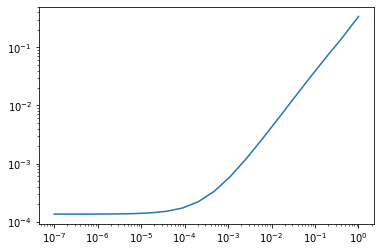

In [57]:
plt.plot(tests,abs((real_values-approx)/real_values/tests))
plt.xscale("log")
plt.yscale("log")


Starting PDHG
Finished in 6.413139820098877 seconds.

Starting Conjugate Gradient method
||Ax-b||/||b||: 0.020553376890838835


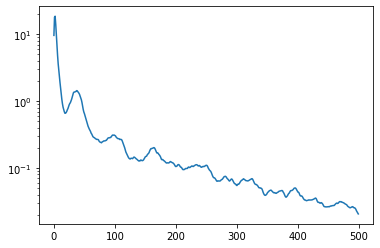

In [50]:
gP = grad_E(p0,max_cgiter=500,compute_conv=True)
plt.plot(cgconv)
plt.yscale("log")

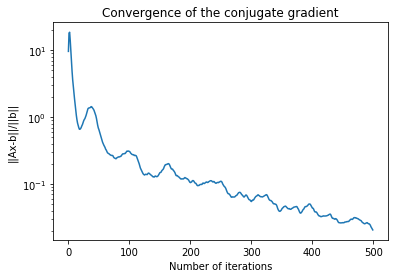

In [51]:
plt.plot(cgconv)
plt.yscale("log")
plt.title("Convergence of the conjugate gradient")
plt.xlabel("Number of iterations")
plt.ylabel("||Ax-b||/||b||")
plt.savefig("Upper Level/CG_conv.png")

# L-BFGS-B

In [62]:
p0 = 0.9*p+0.1*np.random.rand(n**2+1)
#p0 = np.random.rand(n**2+1)
p0=np.ones(n**2+1)
p0[-1] = 1e-6

niter = 0
res = scipy.optimize.minimize(E,p,method='L-BFGS-B',jac=grad_E
                              ,bounds=[(0,1)]*n**2+[(0,np.inf)]
                              ,callback=fcall
                              ,options={'gtol':1e-15,'maxiter':4,'maxfun':4})


Evaluating E(p)
Finished in 6.653294801712036 seconds.

Starting PDHG
Finished in 6.63750696182251 seconds.

Starting Conjugate Gradient method
Finished in 37.93353867530823s - ||Ax-b||/||b||: 36.200326118848615

Evaluating E(p)
Finished in 6.72201943397522 seconds.

Starting PDHG
Finished in 6.706202745437622 seconds.

Starting Conjugate Gradient method
Finished in 38.04250121116638s - ||Ax-b||/||b||: 20.20854651760758

Evaluating E(p)


KeyboardInterrupt: 

In [63]:
pf = res.x
print(E(p),E(pf))

NameError: name 'res' is not defined

In [99]:
print(pf[-1])
pysap.Image(data=np.reshape(pf[:-1],(n,n))).show()

1.044576172541336e-06


/home/guillaume/anaconda3/lib/python3.7/site-packages/pyqtgraph/functions.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  data = rescaleData(data, scale/(maxVal-minVal), minVal, dtype=dtype)
/home/guillaume/anaconda3/lib/python3.7/site-packages/pyqtgraph/functions.py:870: RuntimeWarning: invalid value encountered in multiply
  d2 *= scale


10  iterations:
Cost: 8.772578054456486e-08 
Norm: 0.07050469994161677 

20  iterations:
Cost: 8.429884305595803e-08 
Norm: 0.006174075634777439 

30  iterations:
Cost: 8.385403999321318e-08 
Norm: 0.0015817253406313408 

40  iterations:
Cost: 8.376926936833475e-08 
Norm: 0.0007687368822694923 

50  iterations:
Cost: 8.374813239832085e-08 
Norm: 0.0005397526683627604 

60  iterations:
Cost: 8.373893173324553e-08 
Norm: 0.0004308719958126561 

70  iterations:
Cost: 8.373347463428974e-08 
Norm: 0.00035569521872293327 

80  iterations:
Cost: 8.37292153760354e-08 
Norm: 0.00030676387099849137 

90  iterations:
Cost: 8.372661939592902e-08 
Norm: 0.0002740064426511952 

100  iterations:
Cost: 8.372482124121226e-08 
Norm: 0.0002488539777065706 

Finished in 55.96584486961365 seconds.
0.9194274622137819


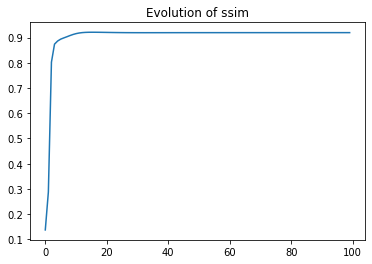

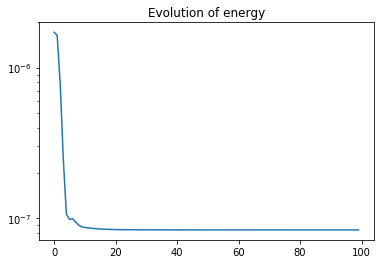

In [89]:
uk,norms,energy,ssims = pdhg(y,pf[:-1],fourier_op,linear_op,param,real_image=u0_mat,maxit=100)
print(ssim(uk,u0_mat))

plt.figure()
plt.plot(ssims)
plt.title("Evolution of ssim")
plt.show()

plt.figure()
plt.plot(energy)
plt.title("Evolution of energy")
plt.yscale("log")
plt.show()

pysap.Image(data=uk).show()